## Agentnet intro

In this tutorial we build above the [basic tutorial](http://bit.ly/29EvHvZ) withsome new algorithms
* this time we're solving KungFuMaster
* use single-layer LSTM on top of convolutional layers
* actor-critic with n-step critic objective and n-step advantage for actor

In [1]:
#setup theano/lasagne. Prefer GPU
%env THEANO_FLAGS=device=gpu0,floatX=float32

env: THEANO_FLAGS=device=gpu0,floatX=float32


In [2]:
#If you are running on a server, launch xvfb to record game videos
#Please make sure you have xvfb installed
import os
if os.environ.get("DISPLAY") is str and len(os.environ.get("DISPLAY"))!=0:
    !bash ../xvfb start
    %env DISPLAY=:1



# Experiment setup
* Here we basically just load the game and check that it works

In [3]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

#number of parallel agents and batch sequence length (frames)
N_AGENTS = 10
SEQ_LENGTH = 25

Using gpu device 0: GeForce GTX 1080 (CNMeM is enabled with initial size: 45.0% of memory, cuDNN 5105)
[2017-02-21 20:34:31,740] Making new env: KungFuMaster-v0


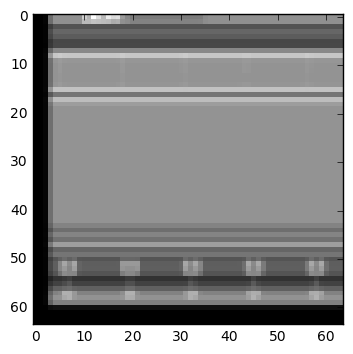

In [4]:
import gym
from agentnet.experiments.openai_gym.wrappers import PreprocessImage
#game maker consider https://gym.openai.com/envs
def make_env():
    env = gym.make("KungFuMaster-v0")
    return PreprocessImage(env,height=64,width=64,
                           grayscale=True,
                           crop=lambda img:img[50:])

#spawn game instance
env = make_env()
observation_shape = env.observation_space.shape
n_actions = env.action_space.n

obs = env.step(0)[0]

plt.imshow(obs[0],interpolation='none',cmap='gray')

# Basic agent setup
Here we define a simple agent that maps game images into Qvalues using simple convolutional neural network.

![scheme](https://s18.postimg.org/gbmsq6gmx/dqn_scheme.png)

In [5]:
import theano, lasagne
import theano.tensor as T
from lasagne.layers import *

In [6]:
#observation
observation_layer = InputLayer((None,)+observation_shape,)

#4-tick window over images
from agentnet.memory import WindowAugmentation, LSTMCell

prev_wnd = InputLayer((None,4)+observation_shape)
new_wnd = WindowAugmentation(observation_layer,prev_wnd)
        
#reshape to (frame, h,w). If you don't use grayscale, 4 should become 12.
wnd_reshape = reshape(new_wnd, (-1,4*observation_shape[0])+observation_shape[1:])


In [7]:
prev_wnd.output_shape,new_wnd.output_shape

((None, 4, 1, 64, 64), (None, 4, 1, 64, 64))

In [8]:
from lasagne.nonlinearities import elu,tanh,softmax

#network body
conv0 = Conv2DLayer(wnd_reshape,32,5,stride=2,nonlinearity=elu)
conv1 = Conv2DLayer(conv0,32,5,stride=2,nonlinearity=elu)
conv2 = Conv2DLayer(conv1,64,5,stride=2,nonlinearity=elu)
        
dense = DenseLayer(dropout(conv2,0.1),512,nonlinearity=tanh,name='dense')

In [9]:

prev_cell = InputLayer((None,256))
prev_out = InputLayer((None,256))

new_cell,new_out = LSTMCell(prev_cell,prev_out,name='lstm')

In [10]:
#actor head
logits_layer = DenseLayer(concat([dense,new_out]),n_actions,nonlinearity=None) 
#^^^ store policy logits to regularize them later
policy_layer = NonlinearityLayer(logits_layer,softmax)

#critic head
V_layer = DenseLayer(concat([dense,new_out]),1,nonlinearity=None)

#sample actions proportionally to policy_layer
from agentnet.resolver import ProbabilisticResolver
action_layer = ProbabilisticResolver(policy_layer)



In [11]:
from agentnet.target_network import TargetNetwork
targetnet = TargetNetwork(V_layer)
V_old = targetnet.output_layers

##### Finally, agent
We declare that this network is and MDP agent with such and such inputs, states and outputs

In [12]:
from agentnet.agent import Agent
#all together
agent = Agent(observation_layers=observation_layer,
              policy_estimators=(logits_layer,V_layer,V_old),
              agent_states={new_wnd:prev_wnd,new_cell:prev_cell,new_out:prev_out},
              action_layers=action_layer)


In [13]:
#Since it's a single lasagne network, one can get it's weights, output, etc
weights = lasagne.layers.get_all_params([V_layer,policy_layer],trainable=True)
weights

[W,
 b,
 W,
 b,
 W,
 b,
 dense.W,
 dense.b,
 lstm.b_to_ingate,
 lstm.W_ctrl0_to_ingate,
 lstm.b_to_forgetgate,
 lstm.W_ctrl0_to_forgetgate,
 lstm.b_to_cell,
 lstm.W_ctrl0_to_cell,
 lstm.b_to_outgate,
 lstm.W_ctrl0_to_outgate,
 lstm.W_cell_to_ingate_peephole.scales,
 lstm.W_cell_to_forgetgate_peephole.scales,
 lstm.W_cell_to_outgate_peephole.scales,
 W,
 b,
 W,
 b]

# Create and manage a pool of atari sessions to play with

* To make training more stable, we shall have an entire batch of game sessions each happening independent of others
* Why several parallel agents help training: http://arxiv.org/pdf/1602.01783v1.pdf
* Alternative approach: store more sessions: https://www.cs.toronto.edu/~vmnih/docs/dqn.pdf

In [14]:
from agentnet.experiments.openai_gym.pool import EnvPool

pool = EnvPool(agent,make_env, N_AGENTS) #may need to adjust


[2017-02-21 20:34:33,360] Making new env: KungFuMaster-v0
[2017-02-21 20:34:33,418] Making new env: KungFuMaster-v0
[2017-02-21 20:34:33,462] Making new env: KungFuMaster-v0
[2017-02-21 20:34:33,499] Making new env: KungFuMaster-v0
[2017-02-21 20:34:33,533] Making new env: KungFuMaster-v0
[2017-02-21 20:34:33,571] Making new env: KungFuMaster-v0
[2017-02-21 20:34:33,608] Making new env: KungFuMaster-v0
[2017-02-21 20:34:33,646] Making new env: KungFuMaster-v0
[2017-02-21 20:34:33,684] Making new env: KungFuMaster-v0
[2017-02-21 20:34:33,721] Making new env: KungFuMaster-v0


In [15]:
%%time
#interact for 7 ticks
_,action_log,reward_log,_,_,_  = pool.interact(10)

print('actions:')
print(action_log[0])
print("rewards")
print(reward_log[0])

actions:
[10  1  5 13  8  1  7  0  5 12]
rewards
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
CPU times: user 236 ms, sys: 12 ms, total: 248 ms
Wall time: 247 ms


In [16]:
#load first sessions (this function calls interact and remembers sessions)
pool.update(SEQ_LENGTH)

# Advantage actor-critic

* An agent has a method that produces symbolic environment interaction sessions
* Such sessions are in sequences of observations, agent memory, actions, q-values,etc
  * one has to pre-define maximum session length.

* SessionPool also stores rewards, alive indicators, etc.
* Code mostly copied from [here](https://github.com/yandexdataschool/tinyverse/blob/0b359aa6a5a9f666d2fa9eab97669c7930b7acb3/atari.py)

In [17]:
#get agent's Qvalues obtained via experience replay
#we don't unroll scan here and propagate automatic updates
#to speed up compilation at a cost of runtime speed
replay = pool.experience_replay

_,_,_,_,(logits_seq,V_seq,old_V_seq) = agent.get_sessions(
    replay,
    session_length=SEQ_LENGTH,
    experience_replay=True,
    unroll_scan=False,
)

auto_updates = agent.get_automatic_updates()


/anaconda3/envs/py27/lib/python2.7/site-packages/agentnet/utils/logging.py:14: UserWarning: [Verbose>=2] Recurrent loop without unroll_scan got nonempty random state updates list. That happened because there is some source of randomness (e.g. dropout) inside recurrent step graph. To compile such graph, one must either call .get_automatic_updates() right after .get_output and pass these updates to a function when compiling theano.function.
  default_warn("[Verbose>=%s] %s"%(verbosity_level,message),**kwargs)


In [18]:

# compute pi(a|s) and log(pi(a|s)) manually [use logsoftmax]
# we can't guarantee that theano optimizes logsoftmax automatically since it's still in dev
logits_flat = logits_seq.reshape([-1,logits_seq.shape[-1]])
policy_seq = T.nnet.softmax(logits_flat).reshape(logits_seq.shape)
logpolicy_seq = T.nnet.logsoftmax(logits_flat).reshape(logits_seq.shape)
        
# get policy gradient
from agentnet.learning import a2c
elwise_actor_loss,elwise_critic_loss = a2c.get_elementwise_objective(policy=logpolicy_seq,
                                                                     treat_policy_as_logpolicy=True,
                                                                     state_values=V_seq[:,:,0],
                                                                     actions=replay.actions[0],
                                                                     rewards=replay.rewards/100.,
                                                                     is_alive=replay.is_alive,
                                                                     gamma_or_gammas=0.99,
                                                                     n_steps=None,
                                                                     return_separate=True)
        
# add losses with magic numbers 
# (you can change them more or less harmlessly, this usually just makes learning faster/slower)
# also regularize to prioritize exploration
reg_logits = T.mean(logits_seq**2)
reg_entropy = T.mean(T.sum(policy_seq*logpolicy_seq,axis=-1))
loss = 0.1*elwise_actor_loss.mean() + 0.25*elwise_critic_loss.mean() + 1e-3*reg_entropy + 1e-3*reg_logits

        


In [19]:
# Compute weight updates, clip by norm
grads = T.grad(loss,weights)
grads = lasagne.updates.total_norm_constraint(grads,10)

updates = lasagne.updates.adam(grads, weights,1e-4)

#compile train function
train_step = theano.function([],loss,updates=auto_updates+updates)

# Demo run

In [22]:
untrained_reward = np.mean(pool.evaluate(save_path="./records",
                                         record_video=True))

[2017-02-21 20:37:53,468] Making new env: KungFuMaster-v0
[2017-02-21 20:37:53,526] DEPRECATION WARNING: env.spec.timestep_limit has been deprecated. Replace your call to `env.spec.timestep_limit` with `env.spec.tags.get('wrapper_config.TimeLimit.max_episode_steps')`. This change was made 12/28/2016 and is included in version 0.7.0
[2017-02-21 20:37:53,527] Clearing 2 monitor files from previous run (because force=True was provided)
[2017-02-21 20:37:53,550] Starting new video recorder writing to /home/hedgedir/rl_projects/records/openaigym.video.1.27736.video000000.mp4
[2017-02-21 20:37:57,702] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/hedgedir/rl_projects/records')


Episode finished after 931 timesteps with reward=100.0


In [23]:
#show video
from IPython.display import HTML
import os

video_names = list(filter(lambda s:s.endswith(".mp4"),os.listdir("./records/")))

HTML("""
<video width="640" height="480" controls>
  <source src="{}" type="video/mp4">
</video>
""".format("./records/"+video_names[-1])) #this may or may not be _last_ video. Try other indices

# Training loop

In [24]:
#starting epoch
epoch_counter = 1

#full game rewards
rewards = {}
loss,reward_per_tick,reward =0,0,0

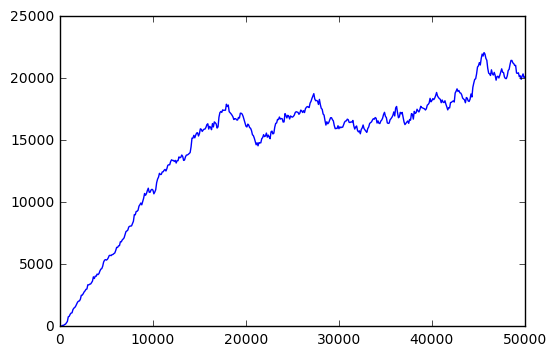

100%|██████████| 50000/50000 [8:26:59<00:00,  2.81s/it]


In [25]:
from tqdm import trange
from IPython.display import clear_output

#the algorithm almost converges by 15k iterations, 50k is for full convergence
for i in trange(50000):    
    
    #play
    pool.update(SEQ_LENGTH)

    #train
    loss = 0.95*loss + 0.05*train_step()
    targetnet.load_weights(0.01)
    
    
    if epoch_counter%10==0:
        #average reward per game tick in current experience replay pool
        reward_per_tick = 0.95*reward_per_tick + 0.05*pool.experience_replay.rewards.get_value().mean()
        print("iter=%i\tloss=%.3f\treward/tick=%.3f"%(epoch_counter,
                                                      loss,
                                                      reward_per_tick))
        
    ##record current learning progress and show learning curves
    if epoch_counter%100 ==0:
        reward = 0.95*reward + 0.05*np.mean(pool.evaluate(record_video=False))
        rewards[epoch_counter] = reward
        
        clear_output(True)
        plt.plot(*zip(*sorted(rewards.items(),key=lambda (t,r):t)))
        plt.show()
        

    
    epoch_counter  +=1

    
# Time to drink some coffee!

# Evaluating results
 * Here we plot learning curves and sample testimonials

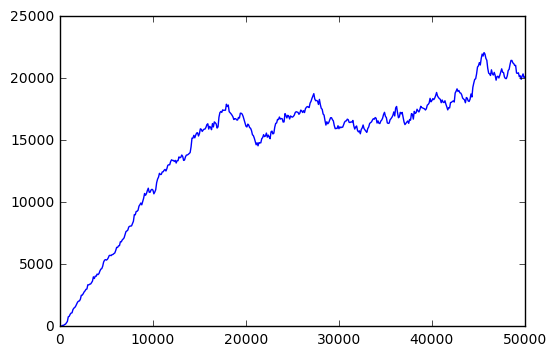

In [26]:
import pandas as pd
plt.plot(*zip(*sorted(rewards.items(),key=lambda k:k[0])))

In [27]:
from agentnet.utils.persistence import save
save(action_layer,"kung_fu.pcl")

In [28]:
###LOAD FROM HERE
from agentnet.utils.persistence import load
load(action_layer,"kung_fu.pcl")

In [ ]:
rw = pool.evaluate(n_games=20,save_path="./records",record_video=True)
print("mean session score=%f.5"%np.mean(rw))

[2017-02-22 05:14:20,638] Making new env: KungFuMaster-v0
[2017-02-22 05:14:20,701] DEPRECATION WARNING: env.spec.timestep_limit has been deprecated. Replace your call to `env.spec.timestep_limit` with `env.spec.tags.get('wrapper_config.TimeLimit.max_episode_steps')`. This change was made 12/28/2016 and is included in version 0.7.0
[2017-02-22 05:14:20,703] Clearing 2 monitor files from previous run (because force=True was provided)


Episode finished after 3300 timesteps with reward=20700.0
Episode finished after 4671 timesteps with reward=35300.0
Episode finished after 3272 timesteps with reward=21200.0
Episode finished after 3275 timesteps with reward=21000.0
Episode finished after 2637 timesteps with reward=14500.0
Episode finished after 3671 timesteps with reward=22200.0
Episode finished after 3433 timesteps with reward=21300.0
Episode finished after 3582 timesteps with reward=24600.0
Episode finished after 4278 timesteps with reward=31700.0


In [ ]:
#show video
from IPython.display import HTML
import os

video_names = list(filter(lambda s:s.endswith(".mp4"),os.listdir("./videos/")))

HTML("""
<video width="640" height="480" controls>
  <source src="{}" type="video/mp4">
</video>
""".format("./videos/"+video_names[-1])) #this may or may not be _last_ video. Try other indices

## How to enhance
* More parallel agents
* Different constructs for recurrent memory
* Try PGQ-like algorithms
* Maybe tune parameters for regularization